<a href="https://colab.research.google.com/github/hrishcoder/mlproject/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!pip install tensorflow

<ipython-input-69-2d3dee41f2b1>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(7,7,1+i)


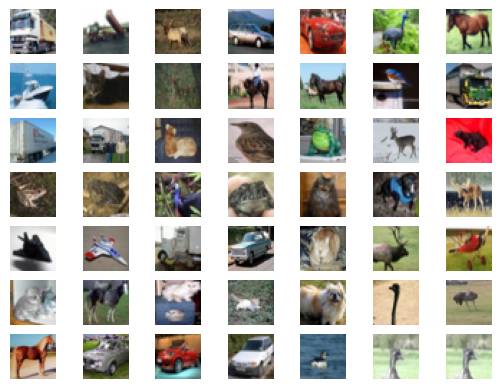

In [69]:
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot



#load the image
(trainX,trainy),(testX,testy)=load_data()
# Normalize pixel values to be between 0 and 1
trainX_norm = trainX / 255.0
#lets display the first 49 images and plot it
for i in range(49):
    # Use the normalized image for plotting
    pyplot.imshow(trainX_norm[i])

    #define the subplot
    pyplot.subplot(7,7,1+i)
    #turn off axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(trainX[i])
pyplot.show()

Now heres the idea we will create 2 neural networks

1. Generator

2.Discriminator

Generator:It will generate images

Discriminator:it will decide whether the image is fake or real

So we will 1st create Generator and then discriminator and then combine them both to form GAN.


In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Conv2D,LeakyReLU,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import numpy as np


In [71]:
def build_discriminator(in_shape=(32,32,3)):#this is the default input so if no input is given then in_shape(32,32,3) will be the default parameter.
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))#since it is taking images as an input so the size of the image would be normal
    model.add(LeakyReLU(alpha=0.2))#we use LeakyRelu as activation function

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))#Then we add conv2d and the decrease the size of the image using strides
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))#here also we decrease the size of the image
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))#again we decrease the size of the image
    model.add(LeakyReLU(alpha=0.2))
    #then we use classifier

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))#here we decide if the value would be between 0 and 1 if the value is close to 0 the it means it is fake else it is real.


    # compile the model
    # Compile the discriminator model with Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)#we are using adam optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])#then we compile the model by giving it 3 parameters 1.optimizer,2.loss function,3.what metrics we are using

    return model#this will return discriminator model.







Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 128)         409728    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 256)        

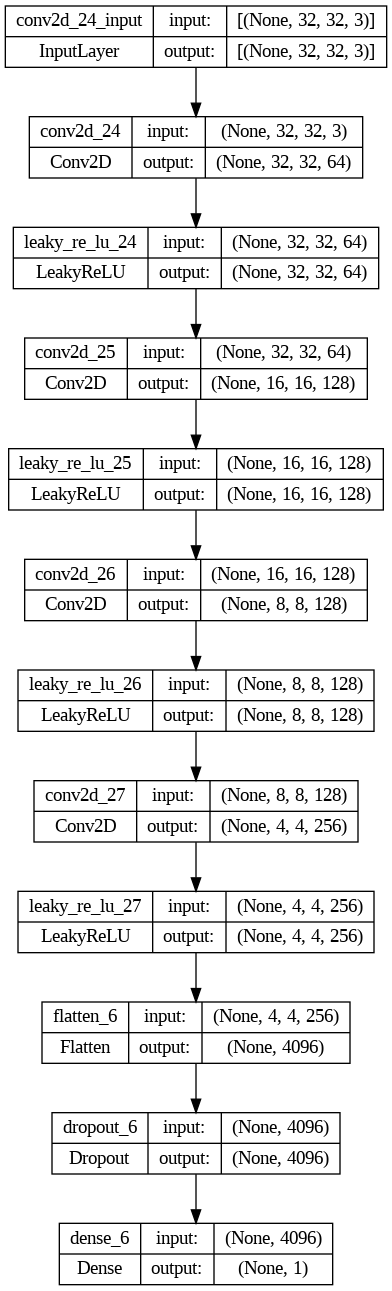

In [72]:
model=build_discriminator()#calling the discriminator function and passing no parameter values so the default parameter i.e in_shape=(32,32,3) will be assigned as the value inside the discriminator function
model.summary()
plot_model(model,to_file='discriminator_plot.png',show_shapes=True,show_layer_names=True)#The arcitecture of the model will be stored at discriminator_plot.img

In [73]:
#lets prepare the dataset
#so as we know we have to give 2 types of data to the model  1st real image and 2nd generated image
def load_samples():
  #load the cifar10 dataset
  (trainX,_),(_,_)=load_data()
  #convert it from ints to float
  X=trainX.astype('float32')
  #since we are dealing with images and the pixel ranges between 0-255, we need convert the range to 1 to -1 since tanh function will get involved and the tanh function would be in the range of 0-255
  X=(X-127.5)/127.5
  return X

In [74]:
X=load_samples()#using load_samples we will call this method which will give image in the form of matrix and the value will range between -1 to 1
X[0]#This will be your first image as we can see it is in matrix format and the value is between -1 to 1.

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215687, -0.01960784, -0.2       ],
        [ 0.16078432, -0.02745098, -0.19215687]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980393, -0.5686275 ],
        [-0.06666667, -0.34901962, -0.60784316],
        [-0.04313726, -0.31764707, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.07450981, -0.34117648, -0.60784316],
        [-0.05882353, -0.34117648, -0.60784316],
        [-0.14509805, -0.42745098, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333334, -0.24705882],
        [ 0

So now as we know we have 50000 images out of which we will send 128 images to the discriminator out of which

64 images would be real and other 64 images would be fake

so we will create 2 functions

1.real image function

2.fake image function



In [75]:
#so in this function we will generate real images where we will select random images from the dataset and label it has 1 since it is a real image.
def generate_real_samples(dataset,n_samples):
  ix=np.random.randint(0,dataset.shape[0],n_samples)#this will take random value from the n_samples
  X=dataset[ix]#then an image is generated randomly from n_sample,so if n_samples is 64 an image will be generated from the randomly but within the range og n_samples i.e 64
  y=np.ones((n_samples,1))#this is a label which will tell us whether the image is real, so 1 means the image is real over here
  return X,y

In [76]:
X,y=generate_real_samples(X,64)#si this function will take 2 parameters 1.X and 2.64 so it means from 50,000 images 64 samples would be given
print(X.shape)#this will print the images
print(y.shape)#this will print the labels
print(y)#as you can see since it is denoting 1 so all the images are real

(64, 32, 32, 3)
(64, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


(64,1) it means all the 64 photos are real

In [77]:
def generate_fake_samples( n_samples):
  #generate the random noise
   X = np.random.rand(32*32*3*n_samples)
   #the noise will range between -1 to 1
   X=-1 + X *2
   #reshape the image
   X=X.reshape((n_samples,32,32,3))
   #label the images as 0 to indicate thatv the image is fake.
   y=np.zeros((n_samples,1))
   return X,y#this will return image as well as labels.

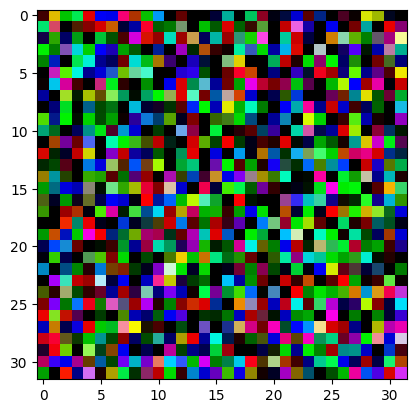

In [78]:
X,y=generate_fake_samples(64)
pyplot.imshow(X[0])

The above image is what we call it has noise.

For discriminator at first few iterations it would be easy for to identify that the image is fake but as we go futher generator will start to generate good quality images such that discriminator will have a diffficult job to identify whether the image is real or fake.

3 things that we need to do

1. create the model

2.create the dataset

3.train the model with the dataset that has been created



In [79]:
# #create a function that will train the discriminator
# def train_discriminator(model,dataset,n_iter=20,n_batches=128):
#   half_batch=int(n_batches/2)#so we divide the batch_size by 2 since we are sending 64 images as a batch everytime
#   for i in range(n_iter):#we will be iterating for 20 times
#     X_real,y_real=generate_real_samples(dataset,half_batch)#this will contain real images
#     _,real_acc=model.train_on_batch(X_real,y_real)#The model will train on real images
#     X_fake,y_fake=generate_real_samples(half_batch)#This will contain fake images
#     _,fake_acc=model.train_on_batch(X_fake,y_fake)#the model will train on fake images
#     # Print summary of discriminator performance
#     print(f"Iteration {i+1}/{n_iter} | Real Accuracy: {100*real_acc:.2f}% | Fake Accuracy: {100*fake_acc:.2f}%")#this will give us the real accuracy and fake accuracy
def train_discriminator(model, dataset, n_iter=20, n_batches=128):
    half_batch = int(n_batches / 2)

    for i in range(n_iter):
        # Train on real samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)

        # Train on fake samples
        X_fake, y_fake = generate_fake_samples( half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)

        # Print summary of discriminator performance
        print(f"Iteration {i+1}/{n_iter} | Real Accuracy: {100*real_acc:.2f}% | Fake Accuracy: {100*fake_acc:.2f}%")


In [80]:
#then we define the model
model=build_discriminator()

#create a dataset
dataset=load_samples()

#train thye model with the dataset
train_discriminator(model,dataset)

Iteration 1/20 | Real Accuracy: 25.00% | Fake Accuracy: 0.00%
Iteration 2/20 | Real Accuracy: 96.88% | Fake Accuracy: 1.56%
Iteration 3/20 | Real Accuracy: 98.44% | Fake Accuracy: 20.31%
Iteration 4/20 | Real Accuracy: 98.44% | Fake Accuracy: 70.31%
Iteration 5/20 | Real Accuracy: 89.06% | Fake Accuracy: 90.62%
Iteration 6/20 | Real Accuracy: 98.44% | Fake Accuracy: 100.00%
Iteration 7/20 | Real Accuracy: 90.62% | Fake Accuracy: 100.00%
Iteration 8/20 | Real Accuracy: 81.25% | Fake Accuracy: 100.00%
Iteration 9/20 | Real Accuracy: 95.31% | Fake Accuracy: 100.00%
Iteration 10/20 | Real Accuracy: 92.19% | Fake Accuracy: 100.00%
Iteration 11/20 | Real Accuracy: 98.44% | Fake Accuracy: 100.00%
Iteration 12/20 | Real Accuracy: 98.44% | Fake Accuracy: 100.00%
Iteration 13/20 | Real Accuracy: 100.00% | Fake Accuracy: 100.00%
Iteration 14/20 | Real Accuracy: 100.00% | Fake Accuracy: 100.00%
Iteration 15/20 | Real Accuracy: 100.00% | Fake Accuracy: 100.00%
Iteration 16/20 | Real Accuracy: 100.0

SO the discriminator is able to identify the images as real or fake.

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.utils import plot_model


#Generator :
it is a neural network it takes input has vectors which is randomly generated and it is of 100 dimensions and that vector is then converted into images.So this is the concept of generator at first it will produce noise but later it will generate images which will look kinda equal to that of the image in the dataset, such that even discriminator cannot identify it


In [82]:
def build_generator(latent_dim):
    model = Sequential()
    #foundation starts from 4X4 and we will upscale to 32X32
    n_nodes=256*4*4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))#so here 256 images will be created of 4X4 the reason is we want to consider all the distribution i.e if we have 3 faces white,black andbrown all of these faces should be given equal weights.
    #upscaling to 8X8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))#since strides=2X2 it will double the pixel size
    model.add(LeakyReLU(alpha=0.2))#we will obviously use leaky relu
    #upscaling to 16X16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upscaling to 32X32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #output layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 8, 8, 128)         409728    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 4, 4, 256)        

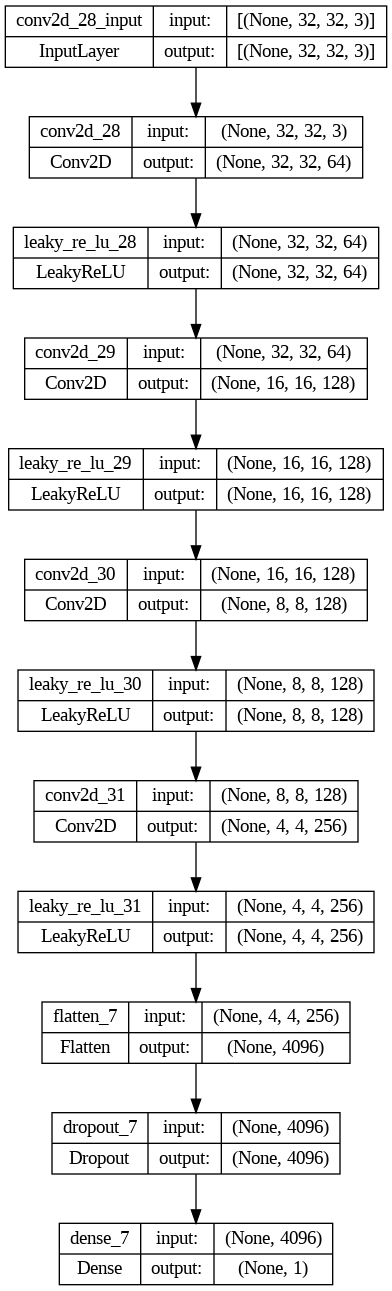

In [83]:
#Define the size of the latent space
latent_dim=100#The ideal dimension should be between 50 to 100
#define the generator model
model.summary()#then we summarize the model
#plot the model
plot_model(model,to_file='generator_plot.png',show_shapes=True,show_layer_names=True)

Now we created the generator arcitecture so now we need to  provide noise to the model so that it will produce a fake image.

since batch=128 we divide it by 2 so 64 images will be real images
and another 64 images would be from fake images,and the fake images would generated from  generator

So now we want to generate a fake image for which we need noise and noise is of 100 vectors so 100 vectors will create an image.

[100] -> image

if i want to generate 64 images then

64[100]=>64 images

In [84]:
#this function will generate the noise which is equal to 64[100]
def generate_noise(n_samples, latent_dim):
    x_input = np.random.randn(latent_dim*n_samples)
    x_input=x_input.reshape(n_samples,latent_dim)
    return x_input

In [85]:
x_input = generate_noise(100,64)
print(x_input.shape)#now we have a noise for us which is 64[100].



(100, 64)


So now the function will generate fake images but this fake images will be generated by generator model rather then us.

So we create a function where generator will create fake images


In [86]:
def generate_images(g_model,latent_dim,n_samples):
    #this will generate noise
    x_input=generate_noise(latent_dim,n_samples)
    #that noise will be given to the model and the model will generate images
    X= g_model.predict(x_input)
    #since the images are fake we will label it has 0's so that we know that the image is fake
    y=np.zeros(n_samples,1)
    return X,y